In [ ]:
# default_exp subcoco_ivf

# Exploring Object Detection using Icevision w/ FastAI

I was unable to make much progress using Pytorch Lightning & Torch Vision on a tiny subset of Coco Dataset. 
I got a model to run for hundreds of epochs, with seemingly improving training loss, but prediction is still garbage.

So I decided to get an end to end object detection working example before diving back in. This time I chose https://github.com/airctic/icevision

Following their [first example](https://airctic.com/examples/training/) for FastAI...

In [ ]:
#export 
import fastai
import glob
import icevision
import icevision.backbones as backbones
import icevision.models
import icevision.models.efficientdet as efficientdet
import icevision.models.rcnn.faster_rcnn as faster_rcnn
import icevision.tfms as tfms
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import PIL
import re
import requests
import tarfile
import sys
import torch
import torch.multiprocessing
import torchvision
import xml.etree.ElementTree

from albumentations import ShiftScaleRotate
from collections import defaultdict
from fastai.test_utils import synth_learner
from fastai.callback.tracker import SaveModelCallback
from icevision.core import BBox
from icevision.parsers import Parser
from icevision.parsers.mixins import LabelsMixin, BBoxesMixin, FilepathMixin, SizeMixin
from fastai.learner import Learner
from fastai.callback.training import GradientAccumulation
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
from icevision.core import ClassMap, BaseRecord
from icevision.data import Dataset
from icevision.metrics.coco_metric import COCOMetricType, COCOMetric
from icevision.utils import denormalize_imagenet
from icevision.visualize.show_data import *
from IPython.utils import io
from pathlib import Path
from PIL import Image, ImageStat
from shutil import copyfile, rmtree
from tqdm import tqdm
from typing import Hashable, List, Tuple, Union

from mcbbox.subcoco_utils import *

torch.multiprocessing.set_sharing_strategy('file_system')

/usr/local/lib/python3.8/dist-packages/graphql/type/directives.py:55: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  assert isinstance(locations, collections.Iterable), 'Must provide locations for directive.'
/usr/local/lib/python3.8/dist-packages/graphql/type/typemap.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import OrderedDict, Sequence, defaultdict


In [ ]:
#hide
from nbdev.showdoc import *

print(f"Python ver {sys.version}, torch {torch.__version__}, torchvision {torchvision.__version__}, fastai {fastai.__version__}, icevision {icevision.__version__}")
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/brian/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Python ver 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0], torch 1.6.0, torchvision 0.7.0, fastai 2.0.16, icevision 0.2.1.post1


## Download a Sample of COCO Data

The full COCO Dataset is huge (~50GB?). For my self education exploring object detection, with the intention of using pretrained model in transfer learning, it is not practical to deal with dataset this big as my first project.  Luckily, the kind folks at [FastAI](https://fast.ai) have prepared some convenient subsets, the medium size 3GB https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz seems like a good candidate.  The 800KB "http://files.fast.ai/data/examples/coco_tiny.tgz" on the other hand seems way too small, thus may not have enough data for adequate training.

In [ ]:
train_json = fetch_subcoco(datadir='/tmp', url='http://files.fast.ai/data/examples/coco_tiny.tgz', img_subdir='train')
img_dir='/tmp/coco_tiny/train'

#train_json = fetch_subcoco(datadir='workspace', url='https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz', img_subdir='train_sample')
#img_dir='workspace/coco_sample/train_sample'

If using tiny Coco subset, use these values:
```
train_json = fetch_subcoco(url='http://files.fast.ai/data/examples/coco_tiny.tgz', img_subdir='train')
```

If using Sample Coco subset, use these values:
```
train_json = fetch_subcoco(url='https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz', img_subdir='train_sample')
```

## Check Annotations

Let's load and inspect the annotation file that comes with the coco tiny dataset...

In [ ]:
train_json['categories'], train_json['images'][0], [a for a in train_json['annotations'] if a['image_id']==train_json['images'][0]['id'] ]

([{'id': 62, 'name': 'chair'},
  {'id': 63, 'name': 'couch'},
  {'id': 72, 'name': 'tv'},
  {'id': 75, 'name': 'remote'},
  {'id': 84, 'name': 'book'},
  {'id': 86, 'name': 'vase'}],
 {'id': 318219, 'file_name': '000000318219.jpg'},
 [{'image_id': 318219,
   'bbox': [505.24, 0.0, 47.86, 309.25],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [470.68, 0.0, 45.93, 191.86],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [442.51, 0.0, 43.39, 119.87],
   'category_id': 72}])

## Digest the Dataset for useful Stats

Do some basic analysis of the data to get numbers like total images, boxes, and average box count per image...

In [ ]:
stats = load_stats(train_json, img_dir=img_dir, force_reload=False)
print(
    f"Categories {stats.num_cats}, Images {stats.num_imgs}, Boxes {stats.num_bboxs}, avg (w,h) {(stats.avg_width, stats.avg_height)}"
    f"avg cats/img {stats.avg_ncats_per_img:.1f}, avg boxs/img {stats.avg_nboxs_per_img:.1f}, avg boxs/cat {stats.avg_nboxs_per_cat:.1f}.")

print(f"Image means by channel {stats.chn_means}, std.dev by channel {stats.chn_stds}")
stats.num_imgs, stats.lbl2name, stats.lbl2cat, stats.cat2lbl, stats.lbl2name

Categories 6, Images 21837, Boxes 87106, avg (w,h) (575.6857626963424, 481.71420066859)avg cats/img 7.0, avg boxs/img 4.0, avg boxs/cat 14517.7.
Image means by channel [115.64436835 103.2992867   91.73613059], std.dev by channel [64.16724017 62.63021182 61.92975836]


(21837,
 {1: 'chair', 2: 'couch', 3: 'tv', 4: 'remote', 5: 'book', 6: 'vase'},
 {1: 62, 2: 63, 3: 72, 4: 75, 5: 84, 6: 86, 0: 0},
 {62: 1, 63: 2, 72: 3, 75: 4, 84: 5, 86: 6, 0: 0},
 {1: 'chair', 2: 'couch', 3: 'tv', 4: 'remote', 5: 'book', 6: 'vase'})

## Custom Parser for Icevision

In [ ]:
#export
def box_within_bounds(x, y, w, h, width, height, min_margin_ratio, min_width_height_ratio):
    min_width = min_width_height_ratio*width
    min_height = min_width_height_ratio*height
    if w < min_width or h < min_height:
        return False
    top_margin = min_margin_ratio*height
    bottom_margin = height - top_margin
    left_margin = min_margin_ratio*width
    right_margin = width - left_margin
    if x < left_margin or x > right_margin:
        return False
    if y < top_margin or y > bottom_margin:
        return False
    return True

class SubCocoParser(Parser, LabelsMixin, BBoxesMixin, FilepathMixin, SizeMixin):
    def __init__(self, stats:CocoDatasetStats, min_margin_ratio = 0, min_width_height_ratio = 0, quiet = True):
        self.stats = stats
        self.data = [] # list of tuple of form (img_id, wth, ht, bbox, label_id, img_path)
        skipped = 0
        for img_id, imgfname in stats.img2fname.items():
            imgf = stats.img_dir/imgfname
            if not os.path.isfile(imgf):
                skipped += 1
                continue
            width, height = stats.img2sz[img_id]
            bboxs = []
            lids = []
            for lid, x, y, w, h in stats.img2lbs[img_id]:
                if lid != None and box_within_bounds(x, y, w, h, width, height, min_margin_ratio, min_width_height_ratio):
                    b = [int(x), int(y), int(w), int(h)]
                    l = int(lid)
                    bboxs.append(b)
                    lids.append(l)
                else:
                    if not quiet: print(f"warning: skipping lxywh of {lid, x, y, w, h}")

            if len(bboxs) > 0:
                self.data.append( (img_id, width, height, bboxs, lids, imgf, ) )
            else:
                skipped += 1

        print(f"Skipped {skipped} out of {stats.num_imgs} images")

    def __iter__(self):
        yield from iter(self.data)

    def __len__(self):
        return len(self.data)

    def imageid(self, o) -> Hashable:
        return o[0]

    def filepath(self, o) -> Union[str, Path]:
        return o[5]

    def height(self, o) -> int:
        return o[2]

    def width(self, o) -> int:
        return o[1]

    def labels(self, o) -> List[int]:
        return o[4]

    def bboxes(self, o) -> List[BBox]:
        return [BBox.from_xywh(x,y,w,h) for x,y,w,h in o[3]]

    def image_width_height(self, o) -> Tuple[int, int]:
        img_id = o[0]
        return self.stats.img2sz[img_id]

## Load Data Using Custom Parser

To prevent bounding boxes being too close to margin or too small, especially after augmentation which performs transformations. 
I would set min_margin_ratio = 0.05, min_width_height_ratio = 0.05.  

However, IceVision 2.0 now has autofix which should address these issues, it does take a long time to run though...

In [ ]:
#export
def parse_subcoco(stats:CocoDatasetStats)->List[List[BaseRecord]]:
    parser = SubCocoParser(stats, min_margin_ratio = 0.05, min_width_height_ratio = 0.05)
    train_records, valid_records = parser.parse(autofix=False)
    return train_records, valid_records

In [ ]:
train_records, valid_records = parse_subcoco(stats)

Skipped 5362 out of 21837 images


## shows images with corresponding labels and boxes

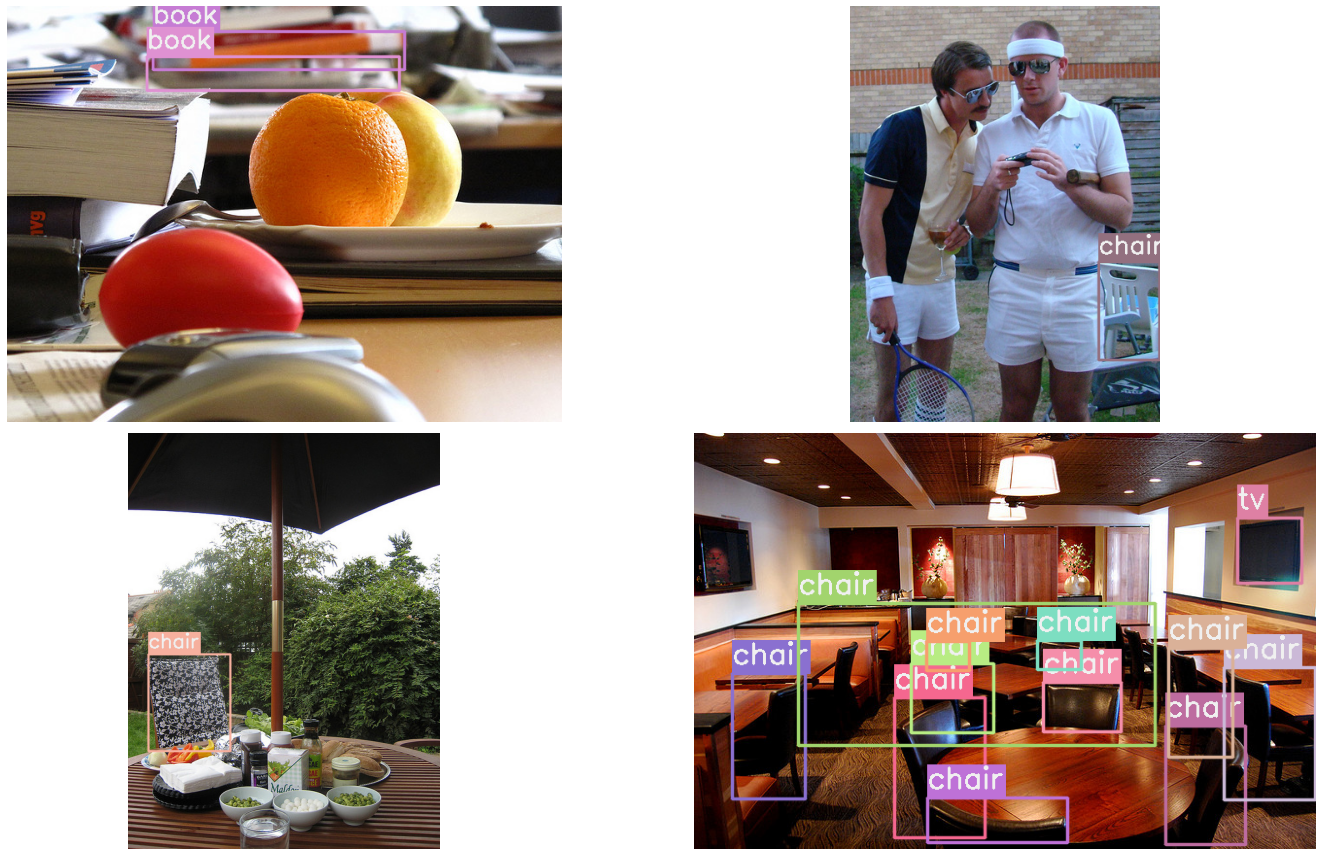

In [ ]:
class_map = ClassMap(list(stats.lbl2name.values()))
show_records(train_records[:4], ncols=2, class_map=class_map, show=True)

## Custom FastAI Callback to Include Metric in Save Model Filename

In [ ]:
#export
class SaveModelDupBestCallback(SaveModelCallback):
    "Extend SaveModelCallback to save a duplicate with metric added to end of filename"
    def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, with_opt=False, reset_on_fit=True):
        super().__init__(
            monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit,
            fname=fname, every_epoch=every_epoch, with_opt=with_opt, 
        )

    def after_epoch(self):
        "Compare the value monitored to its best score and save if best."
        super().after_epoch()
        if self.new_best or self.epoch==0:
            last_saved = self.last_saved_path
            saved_stem = last_saved.stem
            backup_stem = f'{saved_stem}@{self.epoch:03d}_{self.monitor}={self.best:.3f}'
            backup_file = backup_stem+(last_saved.suffix)
            backup_path = last_saved.parent / backup_file
            print(f'Backup {last_saved} as {backup_path}')
            if last_saved != backup_path: copyfile(last_saved, backup_path)

How can I unit test this? Copy idea from [FastAI Callback](https://github.com/fastai/fastai/blob/master/nbs/17_callback.tracker.ipynb)

In [ ]:
#hide
pid = os.getpid()
testpath = Path(f'/tmp/test-{pid}')
learn = synth_learner(n_trn=2, path=testpath)
bestcb = SaveModelDupBestCallback()
learn.fit(n_epoch=1, cbs=bestcb)  # First epoch should trigger best 
assert (testpath/'models/model.pth').exists()
best = bestcb.best
bestpath = f'models/model@000_valid_loss={best:.3f}.pth'
assert (testpath/bestpath).exists(), f'Expect {bestpath} to exist!'
rmtree(testpath)

## Create Transforms, Model, Training and Validation Dataloaders, Learners

* Define transforms - using Albumentations transforms out of the box. 
* Use them to construct Datasets and Dataloaders. 
* Make a Learner

In [ ]:
#export
def gen_transforms_and_learner(stats:CocoDatasetStats, 
                               train_records:List[BaseRecord], 
                               valid_records:List[BaseRecord], 
                               img_sz=128, 
                               bs=4, 
                               acc_cycs=8, 
                               num_workers=2):
    train_tfms = tfms.A.Adapter([
        *tfms.A.aug_tfms(
            size=img_sz,
            presize=img_sz+128,
            shift_scale_rotate = tfms.A.ShiftScaleRotate(shift_limit=.025, scale_limit=0.025, rotate_limit=9)
        ),
        tfms.A.Normalize()
    ]) # mean=stats.chn_means, std=stats.chn_stds
    valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_sz), tfms.A.Normalize()])
    train_ds = Dataset(train_records, train_tfms)
    valid_ds = Dataset(valid_records, valid_tfms)
    # Using gradient accumulation to process minibatch of 32 images in 8 loops, i.e. 8 images per loop.
    # I ran this model w img 512x512x3 on my Dell XPS15 w GTX-1050 with 4GB VRAM, 16GM RAM, ~20min/epoch.
    backbone_name = "tf_efficientdet_lite0"
    model = efficientdet.model(model_name=backbone_name, img_size=img_sz, num_classes=len(stats.lbl2name))
    train_dl = efficientdet.train_dl(train_ds, batch_size=bs, num_workers=num_workers, shuffle=True)
    valid_dl = efficientdet.valid_dl(valid_ds, batch_size=bs, num_workers=max(1,num_workers//2), shuffle=False)

    monitor_metric = 'COCOMetric'
    metrics = [ COCOMetric(metric_type=COCOMetricType.bbox)]

    save_model_fname=f'{backbone_name}-{img_sz}'
    callbacks=[
        GradientAccumulation(bs*acc_cycs),
        SaveModelDupBestCallback(fname=save_model_fname, monitor=monitor_metric),
        EarlyStoppingCallback(monitor=monitor_metric, min_delta=0.001, patience=10)
    ]

    learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics, cbs=callbacks)
    learn.freeze()

    return valid_tfms, learn, backbone_name

In [ ]:
img_sz, bs, acc, workers, head_runs, full_runs = 128, 4, 8, 1, 1, 1
#img_sz, bs, acc, workers, head_runs, full_runs = 512, 4, 8, 4, 20, 200
inf_tfms, learn, backbone_name = gen_transforms_and_learner(stats, train_records, valid_records, 
                                                            img_sz=img_sz, bs=bs, acc_cycs=acc, num_workers=workers)

I have experimented with other models available out of box in IceVision, but ***efficientdet*** works the best. You can replace backbone_name, backbone, model, with the following values to test.

***backbone_name***
* "resnet_fpn.resnet18"

***backbone***
* backbones.resnet_fpn.resnet18(pretrained=True)
* backbones.resnet_fpn.resnet34(pretrained=True)
* backbones.resnet_fpn.resnet50(pretrained=True) # Default
* backbones.resnet_fpn.resnet101(pretrained=True)
* backbones.resnet_fpn.resnet152(pretrained=True)
* backbones.resnet_fpn.resnext50_32x4d(pretrained=True)
* backbones.resnet_fpn.resnext101_32x8d(pretrained=True)
* backbones.resnet_fpn.wide_resnet50_2(pretrained=True)
* backbones.resnet_fpn.wide_resnet101_2(pretrained=True)

***model***
* faster_rcnn.model(backbone=backbone, num_classes=len(stats.lbl2name))


## Train using FastAI

In [ ]:
# # Only do this if GPU avail, otherwise Github CI times out
# if torch.cuda.is_available():
#     learn.lr_find()

In [ ]:
#export
# Wrap in function this doesn't run upon import or when generating docs
def run_training(learn:Learner, min_lr=0.05, head_runs=1, full_runs=1):
    print(f"Training for {head_runs}+{full_runs} epochs at min LR {min_lr}")
    learn.fine_tune(full_runs, min_lr, freeze_epochs=head_runs)

In [ ]:
# Only do this if GPU avail, otherwise Github CI times out
if torch.cuda.is_available():
    run_training(learn, min_lr=0.01, head_runs=head_runs, full_runs=full_runs)

Training for 20+200 epochs at min LR 0.01


Better model found at epoch 0 with COCOMetric value: 7.351462309852022e-05.
Backup models/tf_efficientdet_lite0-512.pth as models/tf_efficientdet_lite0-512@0_COCOMetric=0.000.pth
Better model found at epoch 1 with COCOMetric value: 0.0021581666552511966.
Backup models/tf_efficientdet_lite0-512.pth as models/tf_efficientdet_lite0-512@1_COCOMetric=0.002.pth
Better model found at epoch 2 with COCOMetric value: 0.030757115219257607.
Backup models/tf_efficientdet_lite0-512.pth as models/tf_efficientdet_lite0-512@2_COCOMetric=0.031.pth
Better model found at epoch 3 with COCOMetric value: 0.10474126128636625.
Backup models/tf_efficientdet_lite0-512.pth as models/tf_efficientdet_lite0-512@3_COCOMetric=0.105.pth
Better model found at epoch 4 with COCOMetric value: 0.22112907749246885.
Backup models/tf_efficientdet_lite0-512.pth as models/tf_efficientdet_lite0-512@4_COCOMetric=0.221.pth
Better model found at epoch 5 with COCOMetric value: 0.2825155602494337.
Backup models/tf_efficientdet_lite0-5

Better model found at epoch 0 with COCOMetric value: 0.37343308376504636.
Backup models/tf_efficientdet_lite0-512.pth as models/tf_efficientdet_lite0-512@0_COCOMetric=0.373.pth
Better model found at epoch 1 with COCOMetric value: 0.3834046237982395.
Backup models/tf_efficientdet_lite0-512.pth as models/tf_efficientdet_lite0-512@1_COCOMetric=0.383.pth
Better model found at epoch 2 with COCOMetric value: 0.38497033866151575.
Backup models/tf_efficientdet_lite0-512.pth as models/tf_efficientdet_lite0-512@2_COCOMetric=0.385.pth
Better model found at epoch 3 with COCOMetric value: 0.38712345369355794.
Backup models/tf_efficientdet_lite0-512.pth as models/tf_efficientdet_lite0-512@3_COCOMetric=0.387.pth
Better model found at epoch 6 with COCOMetric value: 0.3940191636756219.
Backup models/tf_efficientdet_lite0-512.pth as models/tf_efficientdet_lite0-512@6_COCOMetric=0.394.pth
Better model found at epoch 9 with COCOMetric value: 0.3984231287870522.
Backup models/tf_efficientdet_lite0-512.pth 

## Inference

/usr/local/lib/python3.8/dist-packages/fastai/callback/core.py:50: UserWarning: You are setting an attribute (__class__) that also exists in the learner, so you're not setting it in the learner but in the callback. Use `self.learn.__class__` otherwise.
  warn(f"You are setting an attribute ({name}) that also exists in the learner, so you're not setting it in the learner but in the callback. Use `self.learn.{name}` otherwise.")


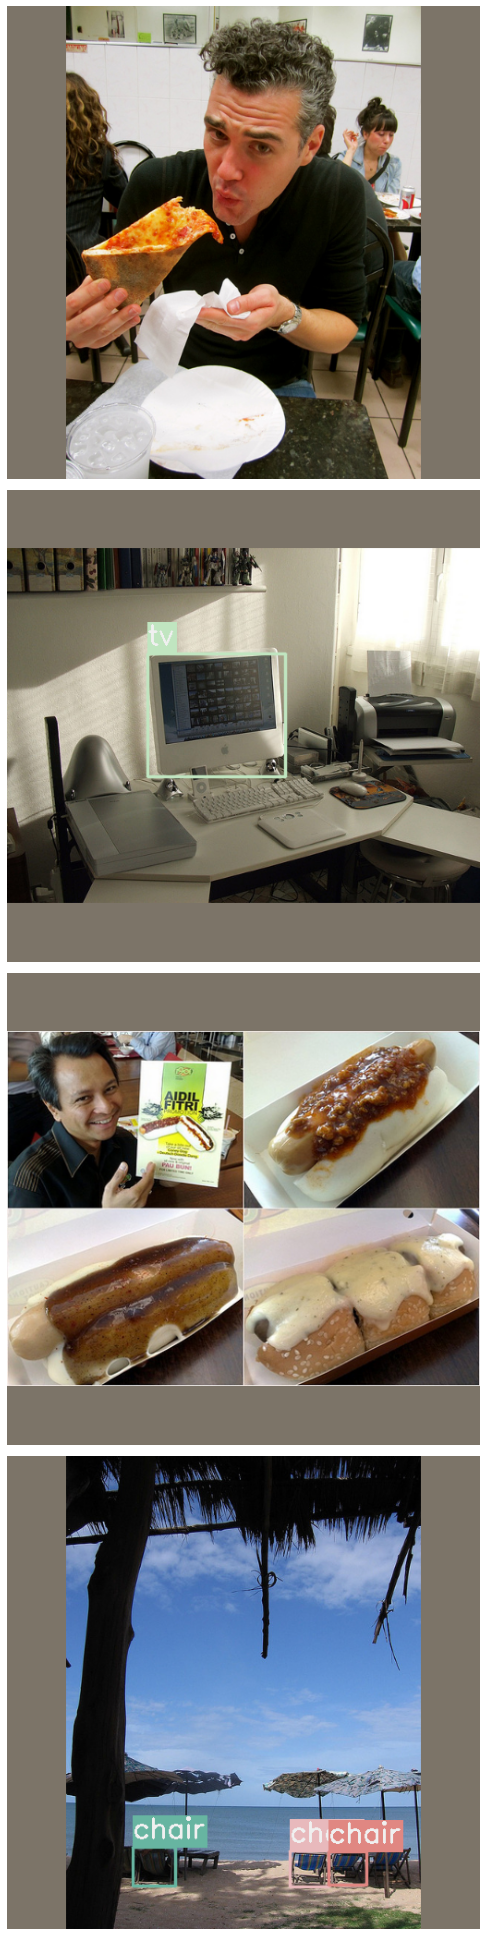

In [ ]:
# Only do this if GPU avail, otherwise Github CI times out
if torch.cuda.is_available():
    infer_ds = Dataset(valid_records[:4], inf_tfms)
    infer_dl = efficientdet.infer_dl(infer_ds, batch_size=4, shuffle=True)
    samples, preds = efficientdet.predict_dl(learn.model, infer_dl)
    imgs = [sample["img"] for sample in samples]
    show_preds(
        imgs=imgs[:4],
        preds=preds[:4],
        class_map=class_map,
        denormalize_fn=denormalize_imagenet,
        ncols=1,
        figsize=(36,27)
    )

As you can see, training after only 2 epochs does not produce a usable model.

## Saving Final Model Explicitly

Saving it explicitly after all the epochs.

In [ ]:
#export
def save_final(learn:Learner, save_model_fpath:str):
    torch.save(learn.model.state_dict(), save_model_fpath)

In [ ]:
final_saved_model_fpath = f"models/{backbone_name}-subcoco-{img_sz}-runs-{head_runs}+{full_runs}-final.pth"
save_final(learn, final_saved_model_fpath)

## Inference w/ Pretrained Model

Load a pretrained model.

In [ ]:
pretrained_model = efficientdet.model(model_name=backbone_name, num_classes=len(stats.lbl2name), img_size=img_sz)
pretrained_model.load_state_dict(torch.load(final_saved_model_fpath))

<All keys matched successfully>

Run Inference with first 4 of the validation image...

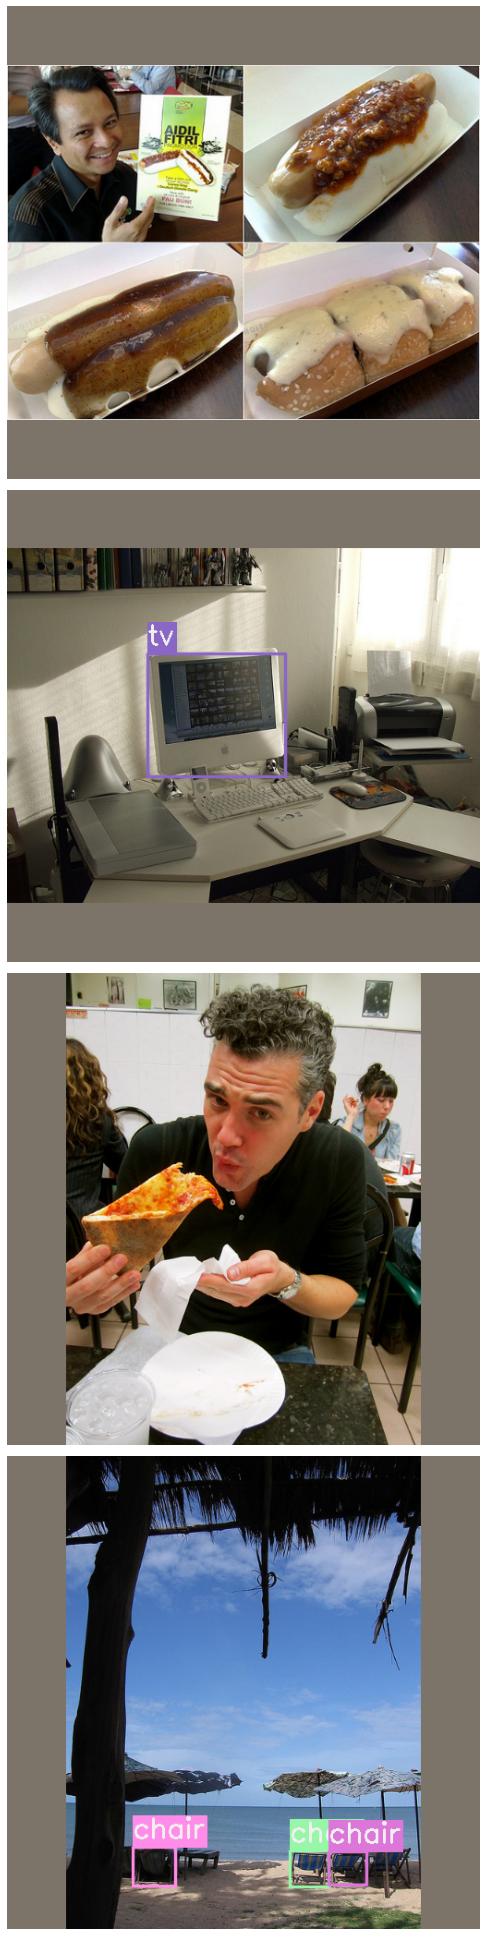

In [ ]:
if torch.cuda.is_available():
    infer_ds = Dataset(valid_records[:4], inf_tfms)
    infer_dl = efficientdet.infer_dl(infer_ds, batch_size=4, shuffle=False)
    samples, preds = efficientdet.predict_dl(pretrained_model.cuda(), infer_dl)
    imgs = [sample["img"] for sample in samples]
    show_preds(
        imgs=imgs[:4],
        preds=preds[:4],
        class_map=class_map,
        denormalize_fn=denormalize_imagenet,
        ncols=1,
        figsize=(36,27)
    )